In [58]:
%load_ext autotime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 0 ns (started: 2022-10-07 00:06:40 +08:00)


In [2]:
x = pickle.load(open('./data/fundamentals3.pkl', 'rb'))
y = pickle.load(open('./data/performance3.pkl', 'rb'))

time: 16 ms (started: 2022-10-06 23:32:09 +08:00)


Remember that our data started from Sep 2016 and runs all the way till Sep 2021.

In [3]:
x

,EV_EBIT,OI_NWCFA,PE,PB,PS,OI_IntExp,WorkingCap,ROE,ROCE,DE,DebtRatio,CashRatio,AssetTurnover,GPM,WC_TA,RE_TA,EBIT_TA,Equity_Liab
0,82.797844,0.054971,112.795556,3.347207,12.792295,11.437500,3.846561,0.029675,0.024383,0.835610,2.196731,2.422222,1.738654,0.529253,0.345137,0.781242,0.021427,1.196731
1,73.741818,0.064395,93.220476,3.642102,14.677638,12.875000,3.337925,0.039070,0.030812,0.830698,2.203807,2.057851,1.633997,0.537957,0.323425,-0.057546,0.026550,1.203807
2,85.881068,0.061131,109.984756,4.122857,16.367967,13.400000,3.201348,0.037486,0.030165,0.832229,2.201593,2.012637,1.632593,0.537205,0.325973,-0.049027,0.025699,1.201593
3,93.118058,0.057908,112.367543,4.264654,17.651993,15.461538,3.219984,0.037953,0.029345,0.791585,2.263288,2.065270,1.555866,0.535009,0.333495,-0.031473,0.024936,1.263288
4,89.891130,0.063609,125.146780,4.581382,18.629924,17.923077,3.300871,0.036608,0.033366,0.742709,2.346422,2.120348,1.570674,0.544155,0.344885,-0.014954,0.028365,1.346422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34497,190.226788,0.162071,263.172831,29.454035,41.218524,600.000000,4.955648,0.111919,0.132893,0.363616,3.750153,2.809967,13.838362,0.789181,0.647814,0.552518,0.111129,2.750153
34498,401.544454,0.027134,455.367693,11.194813,30.310853,281.800000,7.889376,0.024584,0.024432,0.198130,6.047194,5.651679,11.991617,0.785479,0.773617,0.333149,0.021689,5.047194
34499,206.724364,0.041892,278.735919,8.760902,19.453274,459.400000,6.229416,0.031431,0.035773,0.269457,4.711162,3.871998,13.301299,0.778988,0.733024,0.324628,0.030759,3.711162
34500,-451.177169,-0.020088,-738.189122,9.281098,21.600759,-120.111111,6.530220,-0.012573,-0.017744,0.250797,4.987290,3.589801,10.494563,0.756041,0.733442,0.323538,-0.015391,3.987290


time: 16 ms (started: 2022-10-06 23:32:09 +08:00)


In [4]:
# Store the target returns temporarily
returns = y['Returns']
returns = returns.astype('float64')

time: 0 ns (started: 2022-10-06 23:32:10 +08:00)


In [5]:
# Add the Returns column to fundamentals data
x['Returns'] = returns

# Drop the null rows and reset index
x = x.dropna(axis=0)
x = x.reset_index(drop=True)

# Randomise the rows for train-test-split
# Specify frac=1 because we want all the rows back
x = x.sample(frac=1, random_state=42)

time: 16 ms (started: 2022-10-06 23:32:10 +08:00)


After randomizing the rows in the x dataframe (with the targets), we want to split back dataset into x and y

In [6]:
x

,EV_EBIT,OI_NWCFA,PE,PB,PS,OI_IntExp,WorkingCap,ROE,ROCE,DE,DebtRatio,CashRatio,AssetTurnover,GPM,WC_TA,RE_TA,EBIT_TA,Equity_Liab,Returns
9512,61.152309,0.011232,242.849305,1.746777,3.294929,1.873373,2.192989,0.007193,0.016495,1.825444,1.547812,0.562642,1.622053,0.298215,0.277082,0.768904,0.012664,0.547812,0.750888
14921,191.444304,0.055181,230.626925,9.566452,42.739314,-600.000000,4.801513,0.041480,0.045186,0.216496,5.619017,2.996542,1.144513,0.636591,0.528882,0.746598,0.038899,4.619017,0.118316
21084,23.341453,0.052044,24.003479,1.905213,4.938724,11.186488,4.820827,0.079372,0.044871,0.470829,3.123914,2.541647,3.084049,0.271395,0.634056,-0.042379,0.037425,2.123914,2.000000
3806,48.709866,0.040933,83.196719,1.997409,3.334102,-600.000000,2.071990,0.024008,0.031880,0.466795,3.142267,0.847927,1.120338,0.603364,0.269438,0.498095,0.023867,2.142267,-0.329577
14240,-119.286254,-0.018351,-115.973861,1.771494,8.553960,-7.463134,0.934720,-0.015275,-0.009852,1.293939,1.772834,0.003624,0.158042,0.021643,-0.003995,0.092568,-0.009249,0.772834,0.261229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,-500.000000,0.017007,-121.882374,1.055749,22.098571,2.068534,0.788793,-0.008662,-0.000447,0.921518,2.085166,0.292856,0.049423,0.759087,-0.007323,0.100303,-0.000432,1.085166,0.152987
5390,68.340866,0.020240,75.999256,2.859115,8.560492,3.055556,0.938080,0.037620,0.016970,3.838145,1.260543,0.062804,0.092861,0.582187,-0.006329,-0.019620,0.015235,0.260543,0.052348
860,-16.971842,-0.038020,-15.913231,0.634586,0.981254,-37.185246,3.073043,-0.039878,-0.036422,0.299700,4.336665,0.054848,1.921880,0.182595,0.478027,0.000000,-0.028023,3.336665,5.005319
15795,-55.388025,-2.090135,-28.933558,7.046389,10.972469,10.051195,0.560037,-0.243537,-0.040507,3.956257,1.252764,0.209345,3.494393,0.510064,-0.063708,0.754257,-0.034642,0.252764,-0.032547


time: 16 ms (started: 2022-10-06 23:32:10 +08:00)


In [7]:
y = x['Returns']
X = x.drop(columns='Returns')

time: 0 ns (started: 2022-10-06 23:32:10 +08:00)


In [8]:
y.head()

9512     0.750888
14921    0.118316
21084    2.000000
3806    -0.329577
14240    0.261229
Name: Returns, dtype: float64

time: 0 ns (started: 2022-10-06 23:32:10 +08:00)


In [9]:
X.head()

,EV_EBIT,OI_NWCFA,PE,PB,PS,OI_IntExp,WorkingCap,ROE,ROCE,DE,DebtRatio,CashRatio,AssetTurnover,GPM,WC_TA,RE_TA,EBIT_TA,Equity_Liab
9512,61.152309,0.011232,242.849305,1.746777,3.294929,1.873373,2.192989,0.007193,0.016495,1.825444,1.547812,0.562642,1.622053,0.298215,0.277082,0.768904,0.012664,0.547812
14921,191.444304,0.055181,230.626925,9.566452,42.739314,-600.000000,4.801513,0.041480,0.045186,0.216496,5.619017,2.996542,1.144513,0.636591,0.528882,0.746598,0.038899,4.619017
21084,23.341453,0.052044,24.003479,1.905213,4.938724,11.186488,4.820827,0.079372,0.044871,0.470829,3.123914,2.541647,3.084049,0.271395,0.634056,-0.042379,0.037425,2.123914
3806,48.709866,0.040933,83.196719,1.997409,3.334102,-600.000000,2.071990,0.024008,0.031880,0.466795,3.142267,0.847927,1.120338,0.603364,0.269438,0.498095,0.023867,2.142267
14240,-119.286254,-0.018351,-115.973861,1.771494,8.553960,-7.463134,0.934720,-0.015275,-0.009852,1.293939,1.772834,0.003624,0.158042,0.021643,-0.003995,0.092568,-0.009249,0.772834


time: 16 ms (started: 2022-10-06 23:32:10 +08:00)


In [10]:
# Just checking on the baseline annual returns
y.mean()

0.2525233262311269

time: 0 ns (started: 2022-10-06 23:32:10 +08:00)


# Model 1: Linear Regression

In [11]:
y

9512     0.750888
14921    0.118316
21084    2.000000
3806    -0.329577
14240    0.261229
           ...   
21575    0.152987
5390     0.052348
860      5.005319
15795   -0.032547
23654   -0.272628
Name: Returns, Length: 26685, dtype: float64

time: 0 ns (started: 2022-10-06 23:32:10 +08:00)


In [12]:
# We can try with a 80-20 train test split first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('X train: ', X_train.shape)
print('X test: ', X_test.shape)
print('y train: ', y_train.shape)
print('y test: ', y_test.shape)

X train:  (21348, 18)
X test:  (5337, 18)
y train:  (21348,)
y test:  (5337,)
time: 0 ns (started: 2022-10-06 23:32:10 +08:00)


In [13]:
# Define the pipeline
pl_lr = Pipeline([
    ('PowerTransform', PowerTransformer()),
    ('lr', LinearRegression())
])

time: 0 ns (started: 2022-10-06 23:32:10 +08:00)


In [14]:
pl_lr.fit(X_train, y_train)
y_pred = pl_lr.predict(X_test)

time: 359 ms (started: 2022-10-06 23:32:10 +08:00)


In [15]:
mse_train = mean_squared_error(y_train, pl_lr.predict(X_train), squared=True)
mse_test = mean_squared_error(y_test, y_pred, squared=True)
pct_diff = round((1-mse_test/mse_train)*100,3)

print('Train MSE:', mse_train)
print('Test MSE:', mse_test)
print(f'Generalisation: {pct_diff}%')

Train MSE: 1.8711121234175212
Test MSE: 0.897404150297661
Generalisation: 52.039%
time: 32 ms (started: 2022-10-06 23:32:10 +08:00)


We construct the learning curve for the model (where we increase size of learning set and see how predictive ability changes). Cross validation can either be K-fold or ShuffleSplit(), where we randomize rows before the train-test-split. This gives us a better idea of the predictive ability as we are averaging many runs.

In [16]:
# plot the learning curve for different train sizes
trainSizes = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.9]

train_sizes, train_scores, test_scores, fit_times, score_times = \
learning_curve(pl_lr, X, y, cv=ShuffleSplit(n_splits=100, test_size=0.2, random_state=42),
               scoring='neg_mean_squared_error',
               n_jobs=-1, train_sizes=trainSizes,
               return_times=True)

# Create a DataFrame of results
results_df = pd.DataFrame(index=trainSizes)
results_df['train_scores_mean'] = np.sqrt(-np.mean(train_scores,axis=1))
results_df['train_scores_std'] = np.std(np.sqrt(-train_scores), axis=1)
results_df['test_scores_mean'] = np.sqrt(-np.mean(test_scores, axis=1))
results_df['test_scores_std'] = np.std(np.sqrt(-test_scores), axis=1)
results_df['fit_times_mean'] = np.mean(fit_times, axis=1)
results_df['fit_times_std'] = np.std(fit_times, axis=1)
results_df # see results

,train_scores_mean,train_scores_std,test_scores_mean,test_scores_std,fit_times_mean,fit_times_std
0.01,1.125693,0.634882,233188.794774,216827.470241,0.048577,0.007423
0.02,1.102147,0.456643,87224.656999,82889.158684,0.055631,0.008651
0.05,1.276177,0.486028,19962.094850,19197.562428,0.077376,0.015799
0.10,1.295911,0.397185,1105.740913,1082.260842,0.109929,0.015726
0.20,1.289673,0.283448,350.852878,344.997778,0.176801,0.021652
0.50,1.288243,0.177109,3.868821,3.393924,0.372330,0.043796
0.90,1.295620,0.083173,1.274641,0.256189,0.624335,0.059500


time: 22.9 s (started: 2022-10-06 23:32:10 +08:00)


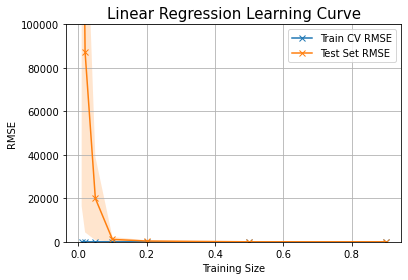

time: 188 ms (started: 2022-10-06 23:32:33 +08:00)


In [17]:
# Plot the train and test score for different train sizes
results_df['train_scores_mean'].plot(style='-x')
results_df['test_scores_mean'].plot(style='-x')

plt.fill_between(results_df.index,\
                 results_df['train_scores_mean']-results_df['train_scores_std'],\
                 results_df['train_scores_mean']+results_df['train_scores_std'],\
                 alpha=0.2)

plt.fill_between(results_df.index,\
                 results_df['test_scores_mean']-results_df['test_scores_std'],\
                 results_df['test_scores_mean']+results_df['test_scores_std'],\
                 alpha=0.2)

plt.grid()
plt.legend(['Train CV RMSE', 'Test Set RMSE'])
plt.ylabel('RMSE')
plt.xlabel('Training Size')
plt.title('Linear Regression Learning Curve', fontsize=15)
plt.ylim([0, 100000]);

In [18]:
# Draw scatter plot to see if prediction matches actual
# Line of x=y will show perfect prediction
# Also draw the best fit line for the scatter plot

def plotScatter(model_name, x_plot, y_plot, limit):
    
    # Plotting scatter
    plt.scatter(x_plot, y_plot, s=1)
    
    # Drawing a best fit line
    # Reshape the y_test and y_pred arrays
    bestfit = LinearRegression().fit(x_plot.reshape(-1, 1), y_plot.reshape(-1, 1))
    xx = [[-5],[5]]
    yy = bestfit.predict(xx)
    plt.plot(xx, yy, 'g')
    
    # Plot formatting
    plt.grid()
    plt.axhline(y=0, color='r', label='_nolegend_')
    plt.axvline(x=0, color='r', label='_nolegend_')
    plt.xlabel('Actual Return')
    plt.ylabel('Predicted Return')
    plt.plot([-100,100], [-100,100], 'y--')
    plt.xlim([-limit, limit])
    plt.ylim([-limit, limit])
    plt.title(f'Scatter plot for {model_name}')
    plt.legend(['Linear Fit Line', 'y=x Perfect Prediction Line', 'Prediction Points'])

time: 0 ns (started: 2022-10-06 23:32:33 +08:00)


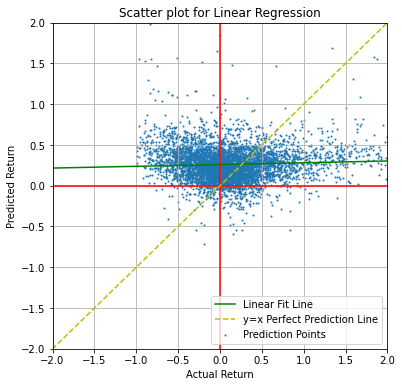

time: 344 ms (started: 2022-10-06 23:32:33 +08:00)


In [19]:
plt.figure(figsize=(6,6))

# need to specify y_test.to_numpy because it is now still in a dataframe, must convert to array
plotScatter('Linear Regression', y_test.to_numpy(), y_pred, 2)

Predictions seemed to be centered around one single value.  We want to take a closer look by taking the top few stock return predictions and comparing them to actual.

In [20]:
def printPredictions(y_test, y_pred):
    # See top 10 predicted annual returns and see how the values differ from actual
    # Put results in a DataFrame so we can sort it.

    y_results = pd.DataFrame()
    y_results['Actual Return'] = y_test
    y_results['Predicted Return'] = y_pred

    # Sort df by the predicted returns.
    y_results.sort_values(by='Predicted Return',
                          ascending=False,
                          inplace=True)

    y_results.reset_index(drop=True, inplace=True)
    
    # Print results
    print('Top Predicted Returns:', \
      list(np.round(y_results['Predicted Return'].iloc[:10],2)))

    print('Comparing Actual Returns:', \
          list(np.round(y_results['Actual Return'].iloc[:10],2)), '\n')

    print('Mean of Top 10 Predicted Returns:', \
          round(y_results['Predicted Return'].iloc[:10].mean(),2) , '%')

    print('Mean of Top 10 Actual Returns:', \
          round(y_results['Actual Return'].iloc[:10].mean(),2) , '%','\n')

    print('Mean of Bottom 10 Predicted Returns:', \
          round(y_results['Predicted Return'].iloc[-10:].mean(),2) , '%')

    print('Mean of Bottom 10 Actual Returns:', \
          round(y_results['Actual Return'].iloc[-10:].mean(),2) , '%','\n')

time: 0 ns (started: 2022-10-06 23:32:34 +08:00)


In [21]:
printPredictions(y_test, y_pred)

Top Predicted Returns: [2.11, 2.11, 2.09, 1.98, 1.85, 1.68, 1.65, 1.58, 1.56, 1.56]
Comparing Actual Returns: [-0.5, 1.01, 0.46, -0.84, 0.0, 1.33, -0.04, 1.83, -0.51, 1.88] 

Mean of Top 10 Predicted Returns: 1.82 %
Mean of Top 10 Actual Returns: 0.46 % 

Mean of Bottom 10 Predicted Returns: -0.54 %
Mean of Bottom 10 Actual Returns: 0.13 % 

time: 16 ms (started: 2022-10-06 23:32:34 +08:00)


## Do a few runs using different random states to see the top/bottom 10 selections and test prediction ability [REDO YOUR CODE HERE]

In [22]:
def testPredictionAbility(pipeline, X, y, nruns):
    '''
    For a given predictor pipeline.
    Create table of top10/bottom 10 averaged, 
    10 rows of 10 random_states.
    to give us a synthetic performance result.    
    Prints Top and Bottom stock picks
    
    The arguments returnSomething=False, verbose=True,
    will be used at the notebook end to get results.
    '''
    
    Top10Pred, Top10Act = [], []
    Bottom10Pred, Bottom10Act = [], []

    for i in range(0, nruns): # Number of runs we want to do
        
        # Train test split with different random states, then fit pipeline and predict
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42+i)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        # Put results in a DataFrame so we can sort it.
        y_results = pd.DataFrame()
        y_results['Actual Return'] = y_test
        y_results['Predicted Return'] = y_pred
        
        # Sort values by the predicted return.
        y_results.sort_values(by='Predicted Return', ascending=False, inplace=True)
        y_results.reset_index(drop=True, inplace=True)
        
        # See top 10 returns and compare how values differ from actual
        Top10Pred.append(round(np.mean(y_results['Predicted Return'].iloc[:10])*100, 2))
        Top10Act.append(round(np.mean(y_results['Actual Return'].iloc[:10])*100, 2))
        
        # See bottom 10 returns and compare how values differ from actual
        Bottom10Pred.append(round(np.mean(y_results['Predicted Return'].iloc[-10:])*100, 2))
        Bottom10Act.append(round(np.mean(y_results['Actual Return'].iloc[-10:])*100, 2))

    # Print out values of performance
    print(f'Predicted Performance (in %) of Top 10 Returns ({nruns} runs):', '\n', Top10Pred)
    print(f'Actual Performance (in %) of Top 10 Returns ({nruns} runs)', '\n', Top10Act, '\n')

    print(f'Predicted Performance (in %) of Bottom 10 Returns ({nruns} runs):', '\n', Bottom10Pred)
    print(f'Actual Performance (in %) of Bottom 10 Returns ({nruns} runs):', '\n', Bottom10Act)
    print('--------------\n')

    # Print out values of Std Dev
    print('Mean Predicted Std. Dev. (in %) of Top 10 Returns:', round(np.array(Top10Pred).std(),2))
    print('Mean Actual Std. Dev. (in %) of Top 10 Returns:', round(np.array(Top10Act).std(), 2))

    print('Mean Predicted Std. Dev. (in %) of Bottom 10 Returns:', round(np.array(Bottom10Pred).std(),2))
    print('Mean Actual Std. Dev. (in %) of Bottom 10 Returns:', round(np.array(Bottom10Act).std(),2))
    print('--------------\n')

    # Average/Mean Performance Measures here
    print('Mean Predicted Performance (in %) of Top 10 Returns:', round(np.mean(Top10Pred), 2))
    print('Mean Actual Performance (in %) of Top 10 Returns:', round(np.mean(Top10Act), 2))
          
    print('Mean Predicted Performance (in %) of Bottom 10 Returns:', round(np.mean(Bottom10Pred), 2))
    print('Mean Actual Performance (in %) of Bottom 10 Returns:', round(np.mean(Bottom10Act), 2))
    print('--------------\n')

    return Top10Act, Bottom10Act

time: 0 ns (started: 2022-10-06 23:32:34 +08:00)


In [23]:
testPredictionAbility(pl_lr, X, y, 10)

Predicted Performance (in %) of Top 10 Returns (10 runs): 
 [181.78, 106.65, 132.28, 152.03, 87.86, 140.36, 110.51, 103.1, 124.27, 120.8]
Actual Performance (in %) of Top 10 Returns (10 runs) 
 [46.33, 95.62, 52.42, 96.33, 12.2, 68.68, 192.83, 46.93, 60.25, 192.24] 

Predicted Performance (in %) of Bottom 10 Returns (10 runs): 
 [-53.68, -40.37, -42.4, -41.56, -31.64, -42.14, -38.88, -43.78, -48.62, -50.78]
Actual Performance (in %) of Bottom 10 Returns (10 runs): 
 [13.21, 35.22, 18.75, 20.41, 18.1, 34.46, 12.57, 14.8, 25.5, 21.61]
--------------

Mean Predicted Std. Dev. (in %) of Top 10 Returns: 25.8
Mean Actual Std. Dev. (in %) of Top 10 Returns: 57.91
Mean Predicted Std. Dev. (in %) of Bottom 10 Returns: 6.01
Mean Actual Std. Dev. (in %) of Bottom 10 Returns: 7.65
--------------

Mean Predicted Performance (in %) of Top 10 Returns: 125.96
Mean Actual Performance (in %) of Top 10 Returns: 86.38
Mean Predicted Performance (in %) of Bottom 10 Returns: -43.39
Mean Actual Performance (

([46.33, 95.62, 52.42, 96.33, 12.2, 68.68, 192.83, 46.93, 60.25, 192.24],
 [13.21, 35.22, 18.75, 20.41, 18.1, 34.46, 12.57, 14.8, 25.5, 21.61])

time: 3.88 s (started: 2022-10-06 23:32:34 +08:00)


# Model 2: ElasticNet/ Ridge

In [24]:
pl_enet = Pipeline([
    ('Power Transformer', PowerTransformer()),
    ('ElasticNet', ElasticNet()) #l1_ratio=0.00001, alpha=0.001
])

time: 0 ns (started: 2022-10-06 23:32:38 +08:00)


In [25]:
pl_enet.fit(X_train, y_train)
y_pred = pl_enet.predict(X_test)

time: 360 ms (started: 2022-10-06 23:32:38 +08:00)


In [26]:
mse_train = mean_squared_error(y_train, pl_enet.predict(X_train), squared=True)
mse_test = mean_squared_error(y_test, y_pred, squared=True)
pct_diff = round((1-mse_test/mse_train)*100,3)

print('Train MSE:', mse_train)
print('Test MSE:', mse_test)
print(f'Generalisation: {pct_diff}%')

Train MSE: 1.91420941276543
Test MSE: 0.8889195029055034
Generalisation: 53.562%
time: 16 ms (started: 2022-10-06 23:32:38 +08:00)


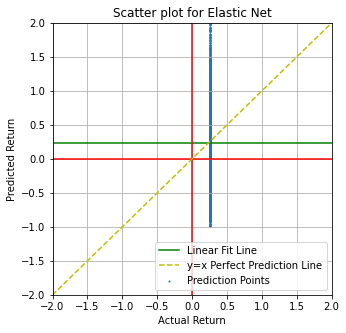

time: 266 ms (started: 2022-10-06 23:32:38 +08:00)


In [27]:
# Scatter plot for pl_enet
plt.figure(figsize=(5,5))
plotScatter('Elastic Net', y_pred, y_test.to_numpy(), 2)

Try again with E-net l1 ratio = 0: Means L2 penalty or Ridge Regression

In [28]:
pl_ridge = Pipeline([
    ('Power Transformer', PowerTransformer()),
    ('ElasticNet', ElasticNet(l1_ratio=0.00001))
])

pl_ridge.fit(X_train, y_train)
y_pred_ridge = pl_ridge.predict(X_test)

time: 328 ms (started: 2022-10-06 23:32:38 +08:00)


In [29]:
mse_train = mean_squared_error(y_train, pl_ridge.predict(X_train), squared=True)
mse_test = mean_squared_error(y_test, y_pred_ridge, squared=True)
pct_diff = round((1-mse_test/mse_train)*100,3)

print('Train MSE:', mse_train)
print('Test MSE:', mse_test)
print(f'Generalisation: {pct_diff}%')

Train MSE: 1.8861919932600286
Test MSE: 0.8812011764851028
Generalisation: 53.281%
time: 31 ms (started: 2022-10-06 23:32:39 +08:00)


Text(0.5, 1.0, 'Ridge Regression')

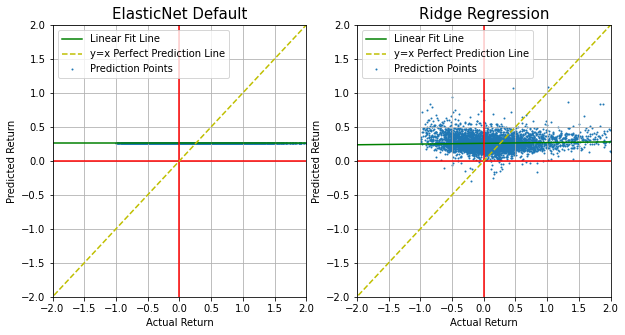

time: 500 ms (started: 2022-10-06 23:32:39 +08:00)


In [30]:
plt.figure(figsize=(10,5))

# Plot the ElasticNet Regression
plt.subplot(1,2,1)
plotScatter('ElasticNet', y_test.to_numpy(), y_pred, 2)
plt.title('ElasticNet Default', fontsize=15)

# Plot the Ridge Regression
plt.subplot(1,2,2)
plotScatter('Ridge', y_test.to_numpy(), y_pred_ridge, 2)
plt.title('Ridge Regression', fontsize=15)

In [31]:
# Predictions for ElasticNet
printPredictions(y_test, y_pred)

Top Predicted Returns: [0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26]
Comparing Actual Returns: [0.36, 0.47, 1.59, 0.08, -0.85, 0.19, 0.3, 0.37, -0.51, -0.07] 

Mean of Top 10 Predicted Returns: 0.26 %
Mean of Top 10 Actual Returns: 0.19 % 

Mean of Bottom 10 Predicted Returns: 0.26 %
Mean of Bottom 10 Actual Returns: 0.78 % 

time: 15 ms (started: 2022-10-06 23:32:39 +08:00)


In [32]:
# Predictions for Ridge
printPredictions(y_test, y_pred_ridge)

Top Predicted Returns: [1.09, 1.08, 0.94, 0.9, 0.86, 0.84, 0.84, 0.83, 0.79, 0.76]
Comparing Actual Returns: [1.01, 0.46, -0.5, 0.0, 1.33, 1.88, 1.83, -0.84, -0.82, -0.45] 

Mean of Top 10 Predicted Returns: 0.89 %
Mean of Top 10 Actual Returns: 0.39 % 

Mean of Bottom 10 Predicted Returns: -0.18 %
Mean of Bottom 10 Actual Returns: 0.17 % 

time: 16 ms (started: 2022-10-06 23:32:39 +08:00)


In [33]:
# Test prediction ability for ElasticNet
testPredictionAbility(pl_enet, X, y, 10)

Predicted Performance (in %) of Top 10 Returns (10 runs): 
 [25.78, 24.93, 25.59, 25.55, 24.37, 25.24, 25.27, 24.93, 25.35, 25.59]
Actual Performance (in %) of Top 10 Returns (10 runs) 
 [19.35, -1.51, 54.68, 30.1, 119.8, 7.51, 29.63, 39.5, 1.2, 6.63] 

Predicted Performance (in %) of Bottom 10 Returns (10 runs): 
 [25.78, 24.93, 25.59, 25.55, 24.37, 25.24, 25.27, 24.93, 25.35, 25.59]
Actual Performance (in %) of Bottom 10 Returns (10 runs): 
 [78.0, 2.6, 56.7, -22.08, 11.91, 5.49, 27.8, 91.69, 1.09, 43.43]
--------------

Mean Predicted Std. Dev. (in %) of Top 10 Returns: 0.4
Mean Actual Std. Dev. (in %) of Top 10 Returns: 34.27
Mean Predicted Std. Dev. (in %) of Bottom 10 Returns: 0.4
Mean Actual Std. Dev. (in %) of Bottom 10 Returns: 34.98
--------------

Mean Predicted Performance (in %) of Top 10 Returns: 25.26
Mean Actual Performance (in %) of Top 10 Returns: 30.69
Mean Predicted Performance (in %) of Bottom 10 Returns: 25.26
Mean Actual Performance (in %) of Bottom 10 Returns: 2

([19.35, -1.51, 54.68, 30.1, 119.8, 7.51, 29.63, 39.5, 1.2, 6.63],
 [78.0, 2.6, 56.7, -22.08, 11.91, 5.49, 27.8, 91.69, 1.09, 43.43])

time: 3.84 s (started: 2022-10-06 23:32:39 +08:00)


In [34]:
# Test prediction ability for Ridge
testPredictionAbility(pl_ridge, X, y, 10)

Predicted Performance (in %) of Top 10 Returns (10 runs): 
 [89.33, 72.49, 70.09, 75.99, 55.66, 71.74, 64.55, 63.92, 68.52, 66.56]
Actual Performance (in %) of Top 10 Returns (10 runs) 
 [39.1, 64.97, 17.13, 194.35, 287.04, 47.02, 243.22, -18.93, 36.75, 33.82] 

Predicted Performance (in %) of Bottom 10 Returns (10 runs): 
 [-17.82, -17.89, -13.19, -11.57, -7.09, -8.08, -7.58, -10.47, -13.9, -15.65]
Actual Performance (in %) of Bottom 10 Returns (10 runs): 
 [16.54, 145.68, 40.7, 136.67, 24.24, 35.86, 7.35, 4.18, 24.63, 17.45]
--------------

Mean Predicted Std. Dev. (in %) of Top 10 Returns: 8.4
Mean Actual Std. Dev. (in %) of Top 10 Returns: 100.61
Mean Predicted Std. Dev. (in %) of Bottom 10 Returns: 3.84
Mean Actual Std. Dev. (in %) of Bottom 10 Returns: 49.13
--------------

Mean Predicted Performance (in %) of Top 10 Returns: 69.88
Mean Actual Performance (in %) of Top 10 Returns: 94.45
Mean Predicted Performance (in %) of Bottom 10 Returns: -12.32
Mean Actual Performance (in %) 

([39.1, 64.97, 17.13, 194.35, 287.04, 47.02, 243.22, -18.93, 36.75, 33.82],
 [16.54, 145.68, 40.7, 136.67, 24.24, 35.86, 7.35, 4.18, 24.63, 17.45])

time: 3.84 s (started: 2022-10-06 23:32:43 +08:00)


Looks like Ridge is better than the default ElasticNet hyperparameters.

# Model 3: KNN Regressor

In [35]:
pl_knn = Pipeline([
    ('Power Transformer', PowerTransformer()),
    ('KNeighborsRegressor', KNeighborsRegressor(n_neighbors=40))])

pl_knn.fit(X_train, y_train)
y_pred = pl_knn.predict(X_test)

time: 593 ms (started: 2022-10-06 23:32:47 +08:00)


In [36]:
mse_train = mean_squared_error(y_train, pl_knn.predict(X_train), squared=True)
mse_test = mean_squared_error(y_test, y_pred, squared=True)
pct_diff = round((1-mse_test/mse_train)*100,3)

print('Train MSE:', mse_train)
print('Test MSE:', mse_test)
print(f'Generalisation: {pct_diff}%')

Train MSE: 1.7737604430390526
Test MSE: 0.8989436692375528
Generalisation: 49.32%
time: 453 ms (started: 2022-10-06 23:32:47 +08:00)


In [37]:
# What is a good value for k? We want to plot train and test errors for different values of k and observe.
knn_validation_list = []
numNeighbours = [4,8,16,32,64,100]
nruns = 10

for i in numNeighbours:
    print('Trying K=' + str(i))
    
    for j in range(0, nruns):
        # Get a new train/test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42+j)
        
        # Define the pipeline
        pl_knn = Pipeline([
            ('Power Transformer', PowerTransformer()),
            ('KNN', KNeighborsRegressor(n_neighbors=i))
            ])
        
        # Fit the pipeline
        pl_knn.fit(X_train, y_train)
        
        # Get the predictions
        y_pred = pl_knn.predict(X_test)
        
        # Store results (Value of k, Train MSE, Test MSE) in a list
        single_result = [i,
                         mean_squared_error(y_train, pl_knn.predict(X_train)),
                         mean_squared_error(y_test, y_pred)]
        
        # Append the results into another list so we can view as dataframe later
        knn_validation_list.append(single_result)

knn_validation_df = pd.DataFrame(knn_validation_list, 
                                 columns=['kNeighbors', 'trainMSE', 'testMSE'])

Trying K=4
Trying K=8
Trying K=16
Trying K=32
Trying K=64
Trying K=100
time: 1min 10s (started: 2022-10-06 23:32:48 +08:00)


In [38]:
knn_validation_df.head()

,kNeighbors,trainMSE,testMSE
0,4,1.093686,0.974644
1,4,0.941687,2.112656
2,4,1.103851,1.036331
3,4,1.063395,1.262504
4,4,0.761081,3.307986


time: 16 ms (started: 2022-10-06 23:33:59 +08:00)


In [39]:
# Get our results in a format we can easily plot
knn_results_list = []
numNeighbours = [4,8,16,32,64,100]

# Create a DataFrame of results, index is the number of Neighbors defined above
results_df = pd.DataFrame(index=numNeighbours)

for i in numNeighbours:
    knn_filter = knn_validation_df['kNeighbors']==i 
    
    # Pass the filter to the dataframe
    trainErrorsMean = knn_validation_df[knn_filter]['trainMSE'].mean()
    trainErrorsStd = knn_validation_df[knn_filter]['trainMSE'].std()
    
    testErrorsMean = knn_validation_df[knn_filter]['testMSE'].mean()
    testErrorsStd = knn_validation_df[knn_filter]['testMSE'].std()
    
    knn_results_list.append([trainErrorsMean, trainErrorsStd,
                             testErrorsMean, testErrorsStd])
    
knn_results_df = pd.DataFrame(knn_results_list,
                              columns=['train_scores_mean','train_scores_std',
                                       'test_scores_mean','test_scores_std'],
                              index=numNeighbours)

time: 15 ms (started: 2022-10-06 23:33:59 +08:00)


In [40]:
knn_results_df

,train_scores_mean,train_scores_std,test_scores_mean,test_scores_std
4,0.992074,0.118800,1.723183,0.767403
8,1.282016,0.153603,1.636182,0.780081
16,1.472417,0.181938,1.641226,0.795574
32,1.571943,0.195339,1.643598,0.804166
64,1.618784,0.197884,1.639673,0.806418
100,1.637127,0.199113,1.640132,0.809127


time: 16 ms (started: 2022-10-06 23:33:59 +08:00)


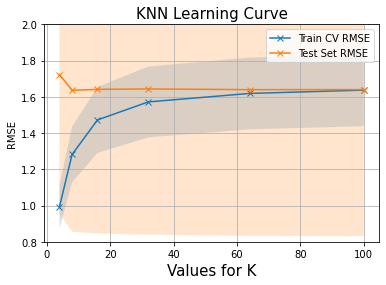

time: 125 ms (started: 2022-10-06 23:33:59 +08:00)


In [41]:
# Plot the learning curve for KNN
knn_results_df['train_scores_mean'].plot(style='-x')
knn_results_df['test_scores_mean'].plot(style='-x')

# Shows the Std Dev of the errors
plt.fill_between(knn_results_df.index,\
                 knn_results_df['train_scores_mean']-knn_results_df['train_scores_std'],\
                 knn_results_df['train_scores_mean']+knn_results_df['train_scores_std'],\
                 alpha=0.2)

plt.fill_between(knn_results_df.index,\
                 knn_results_df['test_scores_mean']-knn_results_df['test_scores_std'],\
                 knn_results_df['test_scores_mean']+knn_results_df['test_scores_std'],\
                 alpha=0.2)

plt.grid()
plt.legend(['Train CV RMSE','Test Set RMSE'])
plt.ylabel('RMSE')
plt.xlabel('Values for K', fontsize=15)
plt.title('KNN Learning Curve', fontsize=15)
plt.ylim([0.8, 2]);

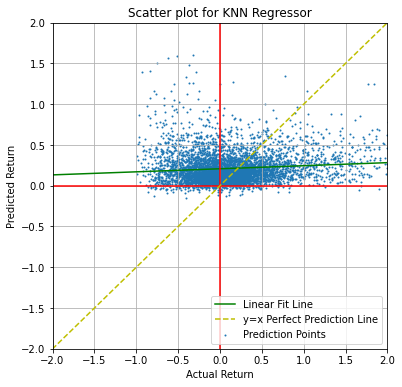

time: 312 ms (started: 2022-10-06 23:33:59 +08:00)


In [42]:
plt.figure(figsize=(6,6))
plotScatter('KNN Regressor', y_test.to_numpy(), y_pred, 2)

In [43]:
printPredictions(y_test, y_pred)

Top Predicted Returns: [1.61, 1.59, 1.56, 1.5, 1.48, 1.47, 1.44, 1.41, 1.4, 1.39]
Comparing Actual Returns: [-0.32, -0.52, -0.62, -0.75, -0.37, 13.6, 5.59, -0.84, -0.29, -0.93] 

Mean of Top 10 Predicted Returns: 1.48 %
Mean of Top 10 Actual Returns: 1.45 % 

Mean of Bottom 10 Predicted Returns: -0.11 %
Mean of Bottom 10 Actual Returns: -0.18 % 

time: 0 ns (started: 2022-10-06 23:33:59 +08:00)


In [44]:
testPredictionAbility(pl_knn, X, y, 10)

Predicted Performance (in %) of Top 10 Returns (10 runs): 
 [177.78, 172.02, 147.88, 156.75, 126.22, 135.49, 165.59, 182.39, 174.95, 148.39]
Actual Performance (in %) of Top 10 Returns (10 runs) 
 [3.08, 11.67, 39.32, 85.69, 133.51, 217.83, 79.85, -36.54, -12.53, 145.43] 

Predicted Performance (in %) of Bottom 10 Returns (10 runs): 
 [-10.0, -11.81, -10.55, -10.77, -8.71, -10.13, -10.47, -8.9, -10.12, -11.09]
Actual Performance (in %) of Bottom 10 Returns (10 runs): 
 [-34.71, -13.71, -34.39, -44.57, -35.98, 6.63, -32.12, 170.42, -30.5, -18.31]
--------------

Mean Predicted Std. Dev. (in %) of Top 10 Returns: 17.99
Mean Actual Std. Dev. (in %) of Top 10 Returns: 76.68
Mean Predicted Std. Dev. (in %) of Bottom 10 Returns: 0.89
Mean Actual Std. Dev. (in %) of Bottom 10 Returns: 60.65
--------------

Mean Predicted Performance (in %) of Top 10 Returns: 158.75
Mean Actual Performance (in %) of Top 10 Returns: 66.73
Mean Predicted Performance (in %) of Bottom 10 Returns: -10.26
Mean Actua

([3.08, 11.67, 39.32, 85.69, 133.51, 217.83, 79.85, -36.54, -12.53, 145.43],
 [-34.71, -13.71, -34.39, -44.57, -35.98, 6.63, -32.12, 170.42, -30.5, -18.31])

time: 7.33 s (started: 2022-10-06 23:33:59 +08:00)


# Model 4: Decision Trees

In [45]:
# Decision Trees dont need to scale
# Try with default hyperparameters
pl_dt = Pipeline([
    ('DecisionTree', DecisionTreeRegressor(random_state=42))
])

time: 0 ns (started: 2022-10-06 23:35:29 +08:00)


In [46]:
pl_dt.fit(X_train, y_train)
y_pred = pl_dt.predict(X_test)

time: 562 ms (started: 2022-10-06 23:36:09 +08:00)


In [47]:
mse_train = mean_squared_error(y_train, pl_dt.predict(X_train), squared=True)
mse_test = mean_squared_error(y_test, y_pred, squared=True)
pct_diff = round((1-mse_test/mse_train)*100,3)

print('Train MSE:', mse_train)
print('Test MSE:', mse_test)
print(f'Generalisation: {pct_diff}%')

Train MSE: 6.495547873144134e-37
Test MSE: 2.4786578281259097
Generalisation: -3.8159334309180125e+38%
time: 15 ms (started: 2022-10-06 23:36:34 +08:00)


Seems like there is alot of overfitting, so we might need to adjust the hyperparameters. We will test with the max_depth hyperparameter to see if we can prevent overfitting.

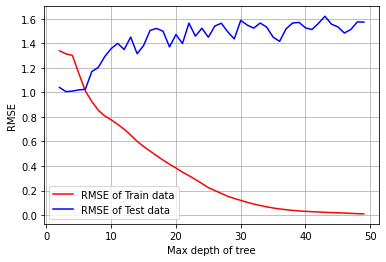

time: 20.1 s (started: 2022-10-06 23:47:58 +08:00)


In [50]:
train_rmse, test_rmse, max_depth = [], [], []

# Try tree depths of 2 to 50
for i in range(2,50):
    
    # define pipeline
    pl_dt_loop = Pipeline([
        ('DecisionTreeRegressor',\
         DecisionTreeRegressor(random_state=42, max_depth=i))])
    
    # fit and predict
    pl_dt_loop.fit(X_train, y_train)
    y_pred = pl_dt_loop.predict(X_test)
    
    # add the errors and max_depth to the lists
    train_rmse.append(mean_squared_error(y_train, pl_dt_loop.predict(X_train)))
    test_rmse.append(mean_squared_error(y_test, y_pred))
    max_depth.append(i)

# Draw on same plot, the RMSE of training data and RMSE of test data given different max_depth
plt.plot(max_depth, np.sqrt(train_rmse), 'r', max_depth, np.sqrt(test_rmse), 'b')

plt.legend(['RMSE of Train data','RMSE of Test data'])
plt.grid()
plt.ylabel('RMSE');
plt.xlabel('Max depth of tree');

Test error does not seem to be decreasing with increasing tree depth. Model still continues to overfit. We can take a value between 10 and 30 as an estimate first. Let's try 15.

In [55]:
# Refit with max depth at 15
pl_dt = Pipeline([('DecisionTree', DecisionTreeRegressor(max_depth=15, random_state=42))])

pl_dt.fit(X_train, y_train)
y_pred = pl_dt.predict(X_test)

mse_train = mean_squared_error(y_train, pl_dt.predict(X_train), squared=True)
mse_test = mean_squared_error(y_test, y_pred, squared=True)
pct_diff = round((1-mse_test/mse_train)*100,3)

print('Train MSE:', mse_train)
print('Test MSE:', mse_test)
print(f'Generalisation: {pct_diff}%')

Train MSE: 0.31244330956907657
Test MSE: 1.9097730617975712
Generalisation: -511.238%
time: 360 ms (started: 2022-10-07 00:02:50 +08:00)


In [56]:
testPredictionAbility(pl_dt, X, y, 10)

Predicted Performance (in %) of Top 10 Returns (10 runs): 
 [4448.33, 1269.0, 1657.33, 2508.42, 1649.37, 1593.4, 2136.92, 1552.5, 1012.5, 1637.75]
Actual Performance (in %) of Top 10 Returns (10 runs) 
 [63.88, 305.17, 6.91, 663.92, 474.36, 389.96, 122.71, 589.52, 426.67, 273.92] 

Predicted Performance (in %) of Bottom 10 Returns (10 runs): 
 [-90.98, -93.87, -92.05, -90.82, -88.9, -95.36, -93.0, -95.64, -93.42, -89.89]
Actual Performance (in %) of Bottom 10 Returns (10 runs): 
 [6.67, 77.57, 13.31, 132.3, 60.61, 834.63, -20.55, 40.31, 143.0, -1.6]
--------------

Mean Predicted Std. Dev. (in %) of Top 10 Returns: 921.39
Mean Actual Std. Dev. (in %) of Top 10 Returns: 208.46
Mean Predicted Std. Dev. (in %) of Bottom 10 Returns: 2.14
Mean Actual Std. Dev. (in %) of Bottom 10 Returns: 241.06
--------------

Mean Predicted Performance (in %) of Top 10 Returns: 1946.55
Mean Actual Performance (in %) of Top 10 Returns: 331.7
Mean Predicted Performance (in %) of Bottom 10 Returns: -92.39
Me

([63.88, 305.17, 6.91, 663.92, 474.36, 389.96, 122.71, 589.52, 426.67, 273.92],
 [6.67, 77.57, 13.31, 132.3, 60.61, 834.63, -20.55, 40.31, 143.0, -1.6])

time: 3.56 s (started: 2022-10-07 00:03:01 +08:00)


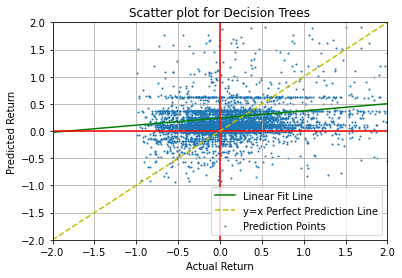

time: 281 ms (started: 2022-10-07 00:03:27 +08:00)


In [57]:
plotScatter('Decision Trees', y_test.to_numpy(), y_pred, 2)

# Model 5: Random Forest

In [60]:
rf = RandomForestRegressor(random_state=42, max_depth=10)

time: 0 ns (started: 2022-10-07 00:10:16 +08:00)


In [61]:
# fit and predict using Random Forest
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

time: 15.8 s (started: 2022-10-07 00:10:45 +08:00)


In [62]:
mse_train = mean_squared_error(y_train, rf.predict(X_train), squared=True)
mse_test = mean_squared_error(y_test, y_pred, squared=True)
pct_diff = round((1-mse_test/mse_train)*100,3)

print('Train MSE:', mse_train)
print('Test MSE:', mse_test)
print(f'Generalisation: {pct_diff}%')

Train MSE: 0.6596168837538992
Test MSE: 0.9885721109881986
Generalisation: -49.871%
time: 140 ms (started: 2022-10-07 00:12:49 +08:00)


In [77]:
# Finding which are the more important features
rf_features = zip(X.keys(), rf.feature_importances_)
df_featimpt = pd.DataFrame(rf_features, columns=['Feature', 'rf_gini'])

# Sort features by importance
df_featimpt = df_featimpt.sort_values(by='rf_gini', ascending=1)

time: 0 ns (started: 2022-10-07 00:35:37 +08:00)


In [78]:
df_featimpt

,Feature,rf_gini
13,GPM,0.019041
12,AssetTurnover,0.025324
16,EBIT_TA,0.031746
6,WorkingCap,0.035866
9,DE,0.039994
0,EV_EBIT,0.042093
17,Equity_Liab,0.047473
1,OI_NWCFA,0.048690
3,PB,0.049390
4,PS,0.049648


time: 0 ns (started: 2022-10-07 00:35:38 +08:00)


Text(0.5, 0, 'Gini Importance')

<Figure size 864x432 with 0 Axes>

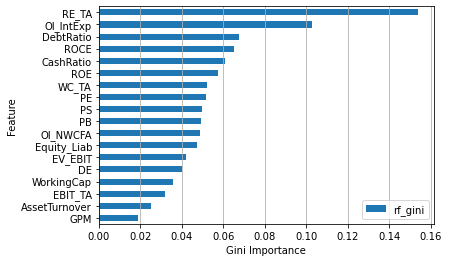

time: 156 ms (started: 2022-10-07 00:36:12 +08:00)


In [80]:
# Plot the feature importance graph
plt.figure(figsize=(12,6))
df_featimpt.plot.barh(x='Feature', y='rf_gini')
plt.grid(axis='x')
plt.ylabel('Feature');
plt.xlabel('Gini Importance')